<a href="https://colab.research.google.com/github/nidanafila/Data-Time-Series/blob/main/Data_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama : Nida Nafila

E-mail : naifanida5858@gmail.com

In [3]:
#install data dari kaggle
!pip install -q kaggle
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

#download dataset
!kaggle datasets download -d shenba/time-series-datasets

!mkdir time-series-datasets
!unzip time-series-datasets.zip -d time-series-datasets
!ls time-series-datasets

Saving kaggle.json to kaggle (1).json
kaggle.json
time-series-datasets.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘time-series-datasets’: File exists
Archive:  time-series-datasets.zip
replace time-series-datasets/Electric_Production.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: time-series-datasets/Electric_Production.csv  
replace time-series-datasets/daily-minimum-temperatures-in-me.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: time-series-datasets/daily-minimum-temperatures-in-me.csv  
replace time-series-datasets/monthly-beer-production-in-austr.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: time-series-datasets/monthly-beer-production-in-austr.csv  
replace time-series-datasets/sales-of-shampoo-over-a-three-ye.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: time-series-datasets/sales-of-shampoo-over-a-three-ye.csv  
daily-minimum-temperatures-in-me.csv  monthly-

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Bidirectional,Dropout
import matplotlib.pyplot as plt

In [9]:
data = pd.read_csv('/content/time-series-datasets/daily-minimum-temperatures-in-me.csv')
data.head()

,Date,Daily minimum temperatures
0,1/1/1981,20.7
1,1/2/1981,17.9
2,1/3/1981,18.8
3,1/4/1981,14.6
4,1/5/1981,15.8


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Date                        3650 non-null   object
 1   Daily minimum temperatures  3650 non-null   object
dtypes: object(2)
memory usage: 57.2+ KB


In [12]:
data['Daily minimum temperatures'] = pd.to_numeric(data['Daily minimum temperatures'], errors = 'coerce')

In [13]:
data.isnull().sum()

Date                          0
Daily minimum temperatures    3
dtype: int64

In [14]:
data.dropna(subset=['Daily minimum temperatures'], inplace = True)
data.isnull().sum()

Date                          0
Daily minimum temperatures    0
dtype: int64

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3647 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        3647 non-null   object 
 1   Daily minimum temperatures  3647 non-null   float64
dtypes: float64(1), object(1)
memory usage: 85.5+ KB


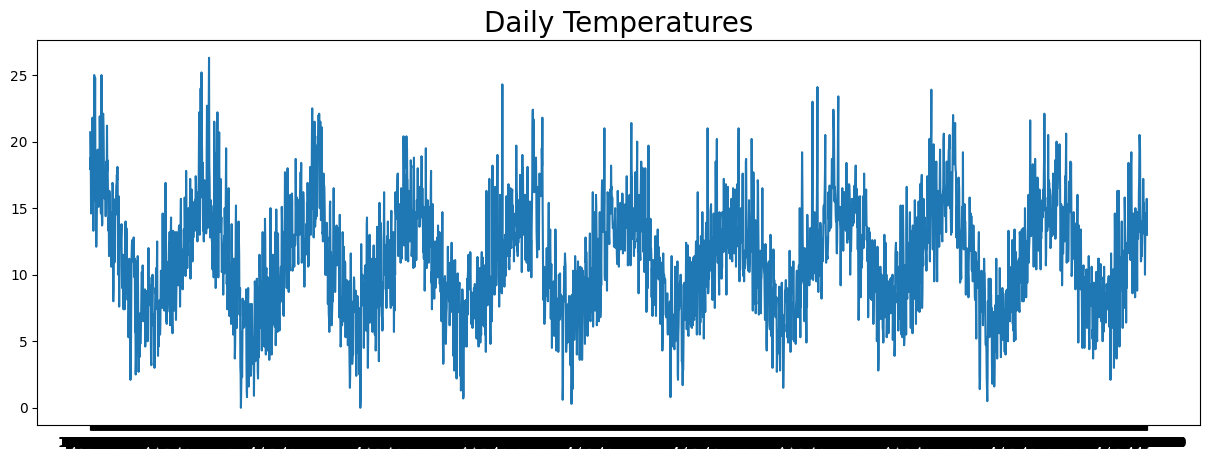

In [16]:
dates = data['Date'].values
temperature = data['Daily minimum temperatures'].values

plt.figure(figsize=(15,5))
plt.plot(dates, temperature)
plt.title('Daily Temperatures',fontsize=20);

In [28]:
x_train, x_valid, y_train, y_valid = train_test_split(temperature, dates, train_size=0.8, test_size = 0.2, shuffle = False )
print('Total Data Train: ',len(x_train))
print('Total Data Validation : ',len(x_valid))

Total Data Train:  2917
Total Data Validation :  730


In [29]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set =  windowed_dataset(x_valid, window_size=60, batch_size=100, shuffle_buffer=1000)

model = Sequential([Bidirectional (LSTM(60, return_sequences=True)),
                    Bidirectional (LSTM(60)), Dense(30, activation = "relu"),
                    Dense(10, activation="relu"),
                    Dense(1),])

Mae = (data['Daily minimum temperatures'].max() - data['Daily minimum temperatures'].min())*10/100
print(Mae)

2.63


In [26]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') <2.63 and logs.get('val_mae')<2.63):
      print("\nMAE < 10% skala data")
      self.model.stop_training = True

callbacks = myCallback()

optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)


In [31]:
model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer, metrics=["mae"])

In [32]:
history = model.fit(train_set, epochs=100, validation_data = val_set, callbacks=[callbacks])

Epoch 1/100
29/29 [==============================] - 14s 140ms/step - loss: 4.1008 - mae: 4.5769 - val_loss: 2.6121 - val_mae: 3.0826
Epoch 2/100
29/29 [==============================] - 1s 31ms/step - loss: 2.2849 - mae: 2.7431 - val_loss: 1.5226 - val_mae: 1.9552
Epoch 3/100
26/29 [=========================>....] - ETA: 0s - loss: 1.7891 - mae: 2.2399
MAE < 10% skala data
29/29 [==============================] - 1s 28ms/step - loss: 1.7811 - mae: 2.2320 - val_loss: 1.5405 - val_mae: 1.9815


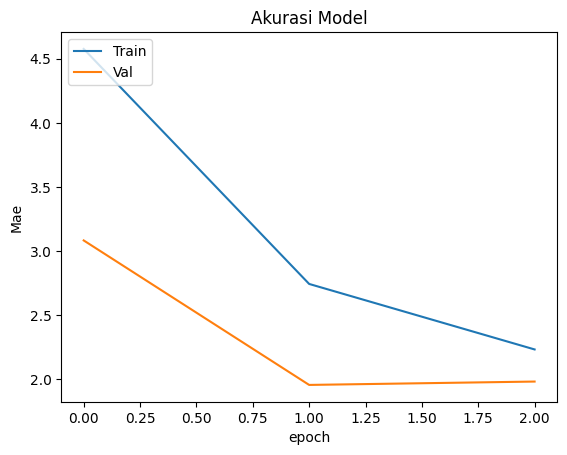

In [33]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Akurasi Model')
plt.ylabel('Mae')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


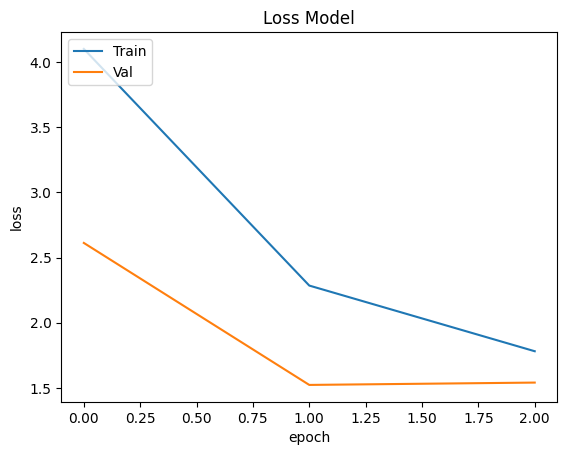

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()